# Simulate gamma ray sources in galaxy

## Imports and definitions

In [1]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
from matplotlib import gridspec
from matplotlib import rc
import matplotlib.ticker
import makemap
rc('font',**{'family':'serif'})
rc('text',usetex=True)

##colors
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'
colors = [c1,c2,c3,c4,c5,c6,c7,c8,c9]

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
#constants 
kpc = 3.08567758e21 #cm

##SNR distribution From Green 2015
alp_snr = 1.09
bet_snr = 3.98
H_snr = 0.083 #jian-wen xu et al 2004

Rsun = 8.3
hb = 10 #This is considered as high latitude

##This is for pulsars
model = 'C' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
if model=='SNR':
    H = 0.083
    alp = alp_snr
    bet = bet_snr
#Trheshold of fermi, from 3fgl paper
fermi_thres = 5e-10

##Setting up some things for later
minflux,maxflux=-14,-6
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.
bins_3fgl = bins
bins_mean_3fgl = bins_mean
#lb regions
lb = [(180,20),(180,5),(180,1),(20,20),(20,5),(20,1)]

##Set up bins for energy for fhl (10-1000GeV) and fgl (0.1-100GeV)
Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
dE_3fgl = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E_3fgl = (E3fgl>=1)&(E3fgl<=100)
#bins in energy for our use (1-1000GeV)
Ebins = np.logspace(0,4,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
mask_E3fhl = E>100
mask_E = (E>=1)&(E<=100)

###From tevcat 
Lmin_tev = 3.96e34
Lmax_tev = 1.79e38

## Function definitions

In [2]:
#Function definitions
from scipy.stats import expon
##Drawing random numbers
def rand_R(n,a,b,Rsun=Rsun):
    "Return random value of R, pdf is above, this is a gamma distribution"
    return np.random.gamma(a+1,1./b,n)*Rsun

def rand_R_norm(n,mu,sig):
    "return normal random"
    return np.random.normal(mu,sig,n)

def rand_R_SNI(n,a,Rsun=Rsun):
    return np.random.exponential(a,n)

def R_SNR_ferriere(R):
    sig1 = 4.8*np.exp(-(R-Rsun)/4.5)
    sig2 = 27*np.where(R < 3.7,3.55*np.exp(-((R-3.7)/2.1)**2),
                   np.exp(-(R**2-Rsun**2)/6.8**2))
    return sig1+sig2

###CDFs for R ferriere only
rspace = np.linspace(0,30,1000)
data_r = R_SNR_ferriere(rspace)
data_r = data_r/np.sum(data_r) #normalize
data_r_cdf = np.cumsum(data_r)#cdf

# def rand_R_SNR_ferriere(N):
#     R_smpl = np.zeros(N)
#     r = np.linspace(0,30,1000)
#     data_r = R_SNR_ferriere(r)
#     data_r = data_r/np.sum(data_r) #normalize
#     data_r_cdf = np.cumsum(data_r)#cdf
#     u = np.random.rand(N)
#     for i in range(N):
#         #Inverse transform sampling, numerical
#         xx= np.argmax(u[i]<=data_r_cdf)
#         R_smpl[i]=r[xx]
#     return R_smpl

def ITS(N,x,cdf):
    """Function to do inverse transform sampling 
    
    Input:
    N: int, number of desired random samples
    x: array, possible returned random samples
    cdf: cdf function
    
    """
    smpl = np.zeros(N)
    u = np.random.rand(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        ix= np.argmax(u[i]<=cdf)
        smpl[i]=x[ix]
    return smpl

# atest=[(1.09,3.98),(0.2,1.4),(1.9,5.0)]
# labels = ['SNR Green','Lorimer S','Lorimer C', 'Ferriere SNRI+II']

# f,ax = plt.subplots(1,figsize=(7,5))
# for i,a in enumerate(atest):
#     ax.hist(rand_R(30000,a[0],a[1]),bins=np.linspace(0,25),label=labels[i],histtype='step',color=colors[i+3])

    
# ax.hist(ITS(30000,rspace,data_r_cdf),bins=np.linspace(0,25),label=labels[3],histtype='step',color=colors[i+4])
# ax.set_xlim([0,20])
# ax.set_xlabel(r'$R \ \mathrm{[kpc]}$',fontsize=16)
# ax.set_ylabel(r'Number of sources',fontsize=16)
# ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
# plt.legend(frameon=False,fontsize=16)
# #plt.savefig('R_hist.pdf')

# plt.close('all')


def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return np.random.laplace(0,H,n)

def z_SNR_ferriere(z):
    "z in pc"
    R1 = 7.3*np.exp(-np.abs(z)/325.)
    R2 = 50 * (0.79*np.exp(-(z/212.)**2)+0.21*np.exp(-(z/636.)**2))
    return R1+R2


###CDFs for z ferriere only
zspace = np.linspace(-3000,3000,1000)
data_z = z_SNR_ferriere(zspace)
data_z = data_z/np.sum(data_z) #normalize
data_z_cdf = np.cumsum(data_z)#cdf

def rand_z_SNR_ferriere(N):
    z_smpl = np.zeros(N)

    u = np.random.rand(N)
    for i in range(N):
        #Inverse transform sampling, numerical
        xx= np.argmax(u[i]<=data_z_cdf)
        z_smpl[i]=z[xx]
    return z_smpl/1000. #kpc

def rand_L(u,a,Lmin,Lmax):
    """Random L generator. Uses inverse transform sampling.
        u is a uniform random number between 0-1, a is the index of the
        power law distributiond desired.
        L = CDF^-1(u)
    """
    if a==1:
        print "a==1, error" #does not work for this..
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))

# Ltest = [1.5,1.8,2.1]
# f,ax = plt.subplots(1,figsize=(7,5))
# for i,l in enumerate(Ltest):
#     ax.hist(rand_L(np.random.rand(30000),l,2e34,2e39),bins=np.logspace(34,39,25), color=colors[i],
#            label='index = %s'%l,histtype='step',log=True)
#     ax.set_xscale('log',nonposx='clip')
#     ax.set_xlabel(r'Luminosity $\rm{ph \ s^{-1}}$',fontsize=16)
#     ax.set_ylabel(r'Number of sources',fontsize=16)
#     ax.set_ylim([0.1,2e4])
#     ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
# plt.legend(frameon=False,fontsize=16)
# plt.savefig('lum_hist.pdf')

def norm_spec(spec,flux,dE,mask):
    """This function normalizes the spec(actually wrong_spec below) 
    to the integrated flux from 1-100GeV
    """
    wrong_spec = spec*flux
    norm = np.sum(wrong_spec[mask]*dE[mask])
    return wrong_spec*flux/norm

def read_catalog(fn,catalog='fgl',classes=['pwn','snr','spp']):
    """
    Reads the catalog, either 3FGL or 3FHL, and returns the average 
    spectrum of the desired sources.
    
    Still have to adjust so that it returns the right spectrum...
    
    Returns also the histogram counts vs flux
    """
    data = fits.getdata(fn)
    tb = Table(data)
    if catalog=='fgl':
        _E = E3fgl
        cls = np.asarray(tb['CLASS1'].tolist())
    else:
        _E = Efhl
        cls = np.asarray(tb['CLASS'].tolist())
    cls = np.char.lower(np.char.rstrip(cls,' '))
    mask = np.zeros_like(cls,dtype=bool)
    lat = tb['GLAT']
    for m in classes:
        mask = (cls==m)|mask


    spec = catalog_spect.get_spec(fn) ###This function returns the spectra of the catalogue  
    
#     maskE_30 = _E > 50
#     mask_f_30 = np.zeros_like(mask,dtype=bool)
#     for i,s in enumerate(spec):
# #         flux_30 = np.sum(s[maskE_30]*E3fgl_dE[maskE_30])
#         slope = np.log10(s[np.argmin(_E<=10)])-np.log10(s[-1])
# #         print s[-1],s[np.argmin(_E>10)],slope
#         if slope < 2.7:
#             mask_f_30[i]=True
# #         if flux_30 > 2e-12:
# #             mask_f_30[i]=True

    if 'non' in classes:
        mask = (mask|(np.abs(lat)<5))#&mask_f_30#&(tb['Signif_Curve']>=4)

    if catalog == 'fgl':
        flux = tb[mask]['Flux1000']
    if catalog == 'fhl':
        flux = tb[mask]['Flux']

    spec = spec[mask]#&mask_f_30]
    ave_spec = 10**np.average(np.log10(spec),axis=0)
    ave_spec = np.average(spec,axis=0)
    hist_3fgl = np.histogram(flux,bins=bins)[0]
    total_flux = np.sum(flux)

    if catalog=='fgl':
        ind = np.mean(tb[mask]['Spectral_Index'])
    if catalog=='fhl':
        ind = np.mean(tb[mask]['PowerLaw_Index'])

    plotfunc = lambda E,a,b: b*(E)**-a
    ind = tb[mask]['Spectral_Index']
   # spec = plotfunc(E,ind,1)
   # spec = ave_spec
    #good_spec = norm_spec(spec,total_flux,dE,mask_E)
    #spec_normed = good_spec/np.max(good_spec)

    return hist_3fgl,ave_spec,spec,ind

def lnlike(model,y):
    "Poisson likelihood, -2lnL"
    k = model
    lmbda = y
    tot = k-lmbda+k*np.log((lmbda+1e-60)/(k+1e-60))
    return -2.*np.sum(tot)

def plot_hist_func(bins,hist,std_hist,hist_norm,options,ft):

    mask_complete = (bins >= ft)
    counts_snr = np.sum(hist[mask_complete])
    Nsnr,LF_i_snr,Lmin_snr,Lmax_snr = options
    f1,ax1 = plt.subplots(1,figsize=(8,6))  
    ax1.loglog(bins,hist,marker='^',label='Simulated sources (N=%s)'%Nsnr, color=c3)

    ax1.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=14,labelbottom='on')
#         ax1.set_ylim([0.5,1e5])
    ax1.fill_between(bins,hist-std_hist,
                     hist+std_hist,where=((hist-std_hist)>0),facecolor=c3,alpha=0.2)
    ax1.fill_between(bins,0,hist+std_hist,where=(((hist-std_hist)<=0)&(hist>0)),
                     facecolor=c3,alpha=0.2)

    ##Plot 3fgl
    ax1.loglog(bins,hist_norm,marker='s',label='CTA DC galactic sources (n=%s)'%np.sum(hist_norm),color=c4)

    #ax1.set_title([Nsnr,LF_i_snr,Lmin_snr])
    ax1.set_xlabel(r'Flux from 3-1000 GeV [ph $\mathrm{cm^{-2} \ s^{-1}}]$',fontsize=16)
    ax1.set_ylabel('Number of sources',fontsize=16)
    
    ax1.set_title(r'$N= %s$, $\rm{index} = %s$, $L_{\rm{min}} = %s$, $L_{\rm max}=%s$, \\ %s at $>$ %s'%(Nsnr, LF_i_snr,Lmin_snr,
                                                                                                         Lmax_snr,
                                                                                    counts_snr,ft),fontsize=20)

    ax1.set_ylim([0.7,5e4])
#         ax2 = ax1.twinx()
#     ax1.loglog(bins_mean,np.cumsum(ave_hist_snr[::-1])[::-1],marker='^',color=c5,label=r'Simulation $N(>S)$')
#     ax1.loglog(bins_mean,np.cumsum(hist_CTA[::-1])[::-1],marker='s',color=c6,label=r'CTA DC $N(>S)$')

#         ax2.set_ylabel(r'$N(N>S)$',fontsize=16)

#         ax2.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=14,labelbottom='on')
    ax1.legend(prop={'size':18},frameon=False,handlelength=2.3)
#         ax2.legend(prop={'size':18},frameon=False,handlelength=2.3)
    save = False
    if save:
        plt.savefig('flux_counts_hist_ops_%s_%s_%s_C.pdf'%(Nsnr,LF_i_snr,Lmin_snr))

## Load catalogue

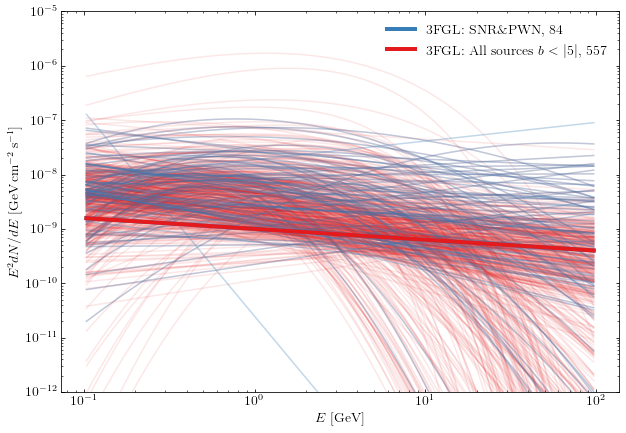

In [3]:
##Load 3fgl data and get average spectrum and histogram of fluxes from here
###The spectrum was fitted so that we can use the analytical expression bellow. So this is now not really needed.
##

file_3fgl = 'gll_psc_v16.fit'
func_log = lambda E,p: p[0]*(E/p[1])**(-p[2]-p[3]*np.log(E/p[1]))
func_Exp = lambda E,p: p[0]*(E/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(E/p[3])**p[4])

###Only hard sources (SNR and PWN (spp=either of those not identified))
hist_3fgl_roi,ave_spec_3fgl_roi,spec_3fgl_roi,indices = read_catalog('gll_psc_v16.fit',catalog='fgl',
                                                            classes=['non'])

hist_3fgl_snr,ave_spec_3fgl_snr,spec_3fgl_snr,indices = read_catalog('gll_psc_v16.fit',catalog='fgl',
                                                            classes=['snr','pwn','spp'])

ave_spec_3fgl_snr = 1e-9*E3fgl**-2.2
ave_spec_3fgl_roi = 1e-9*E3fgl**-2.2

ave_spec_3fgl = 1e-9*E**-2.2

f,ax = plt.subplots(1,figsize=(10,7))
for sp in spec_3fgl_snr:
    ax.loglog(E3fgl,E3fgl**2*sp,color=colors[1],alpha=0.3,zorder=2)
ax.loglog(E3fgl,E3fgl**2*ave_spec_3fgl_snr,color=colors[1],label=r'3FGL: SNR\&PWN, %s'%np.sum(hist_3fgl_snr)
          ,alpha=1,lw=4,zorder=9)

for sp in spec_3fgl_roi:
    ax.loglog(E3fgl,E3fgl**2*sp,color=colors[5],alpha=0.1,zorder=1)
ax.loglog(E3fgl,E3fgl**2*ave_spec_3fgl_roi,color=colors[5],
          label=r'3FGL: All sources $b<|5|$, %s'%np.sum(hist_3fgl_roi),alpha=1,lw=4,zorder=10)

ax.set_ylim([1e-12,1e-5])
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
#ax.get_yaxis().set_ticks([])
ax.set_ylabel(r"$E^2 dN/dE$  $\rm [GeV\,cm^{-2} \, s^{-1}]$",fontsize=14)
ax.set_xlabel(r"$E$ [GeV]",fontsize=14)
plt.legend(frameon=False,fontsize=14,loc=1)
# # plt.savefig('unres_source_spec.pdf')

## Load CTA

In [4]:
import readXML

CTA_file = 'catalog_gps_20180124.xml'
CTA_file_lowTS = 'catalog_gps_20180124_lowTS.xml'

flux_CTA,spec_CTA,E_CTA,ra_dec = readXML.flux_spec(CTA_file) ##Flux from 300-1000 GeV ph s^-1 cm^-2

In [5]:
bins_CTA = np.logspace(-17,-10,30)
bins_mean_CTA = (bins_CTA[1:]+bins_CTA[:-1])/2.
hist_CTA = np.histogram(flux_CTA,bins=bins_CTA)[0]

ave_spec_CTA = np.average(spec_CTA,axis=0)

Ebins_CTA = np.logspace(2,5,101)
E_CTA = (Ebins_CTA[1:]+Ebins_CTA[0:-1])/2.
dE_CTA = (Ebins_CTA[1:]-Ebins_CTA[0:-1])
mask_E_CTA = (E_CTA>=300)&(E_CTA<=1000)
ave_spec_CTA = 1e-9*E_CTA**-2.2

ave_spec_CTA = 1e-9*E**-2.2
ave_spec_3fgl_snr = 1e-9*E**-2.2
ave_spec_3fgl_roi = 1e-9*E**-2.2

## Load diffuse data

In [6]:
###Load diffuse flux from skyfact fit
###Here load the diffuse flux at different l,b. To plot some fractions later.

import open_dat
from scipy import optimize

def errfunc(theta,f,x,y,yerr):
    """leastsq function"""
    if isinstance(yerr,int):
        yerr = yerr
    else:
        yerr = yerr/(np.log10(10)*y)
    x = np.log10(x)
    y = np.log10(y)
    model = f(x,theta)
    return np.sum(((y-model)/yerr)**2)

fitf = lambda *args: errfunc(*args)

modelfunc = lambda x,p: p[0]-p[1]*x

model27 = lambda x,p: p[0]-2.7*x

p0 = [-7,2.7]

def fit_index(E,flux,error=1,model=modelfunc,p0=p0):
    #fit,cov = curve_fit(model,np.log10(E),np.log10(flux),sigma=error/(np.log10(10)*flux),p0=p0)
    res = optimize.minimize(fitf,p0,args=(model,E,
                                            flux,error))
    return res["x"],res["hess_inv"]
    #return fit,cov

def read_datfile(datFile):
    "Read dat file and return total gas spec (sum)"
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    total_gas_err = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
            total_gas_err +=datFile[d+'_err']
    return total_gas_spec/deltaE,E_diff,total_gas_err/deltaE

def diffuse_pi0(E):
    spec_diff_lb = []
    diff_index_lb = []
    spec_27_l = []
    spec_dat = []
    plotfunc = lambda E,a,b: b*(E)**-a
    fitfunc = lambda E,a,b: b-a*(E)
    for ilb in lb:
        datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
        spec,E_diff,error = read_datfile(datfile)
        spec_dat.append(spec)
        mask_E_diff = E_diff > 2
        E_diff2 = E_diff
        E_diff = E_diff[mask_E_diff]
        spec = spec[mask_E_diff]
        err = error[mask_E_diff]

        fit,cov = fit_index(E_diff,spec,err,model=modelfunc,p0=[-7,2.7])
        fit27,cov27 = fit_index(E_diff,spec,err,model=model27,p0=[-7])

        ####
        ####This matters a lot!
        diff_index = fit[1]

        fitted_spec = plotfunc(E,diff_index,10**fit[0]) ##If this is a softer spectra this matters a lot!

        spec_diff_lb.append(fitted_spec)
    return spec_diff_lb

diff_lb_3fgl = diffuse_pi0(E3fgl)
diff_lb_CTA = diffuse_pi0(E_CTA)
spec_diff_lb = diffuse_pi0(E)
# plt.loglog(E,E**2*spec_diff_lb[0])
# plt.loglog(E3fgl,E3fgl**2*diff_lb_3fgl[0])
# plt.loglog(E_CTA,E_CTA**2*diff_lb_CTA[0])

## Simulate sources

In [7]:
##This is the galaxy simulation
#Do the simulation of sources

def source_sim(a=1.8,N=30000,Lmin=2e34,Lmax=2e39,alpha=alp,beta=bet,H=H,
               f_t=fermi_thres,spectrum=ave_spec_3fgl,createmap=False, data='3FGL'):

    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth.
    Returns histogram of sources, total flux from sources and average spec from sources and
    fraction of unresolved/diffuse.
    """

    if data == '3FGL':
#         E = E3fgl
#         dE = dE_3fgl
        mask_E = (E>=1)&(E<=100)
        bins=bins_3fgl
#         spec_diff_lb=diff_lb_3fgl
    elif data == 'CTA':
#         E = E_CTA
#         dE = dE_CTA
        mask_E = (E>=300)&(E<=1000)
        bins = bins_CTA
#         spec_diff_lb = diff_lb_CTA
    else:
        print "Error data"
        
    
    
    N = int(N) #no samples just to be sure 
    x0,y0,z0 = Rsun,0,0 #Location of us
    ##
    ##Drawing random numbers here
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    
    if model=='ferriere':
        R_smpl = ITS(N,rspace,data_r_cdf)
        z_smpl = ITS(N,zspace,data_z_cdf)/1000. #kpc
    else:
        z_smpl = rand_z(N,H)
        R_smpl = rand_R(N,alpha,beta)

    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)
    ##Calculate longitude and latitude
    l = np.arctan2((y0-y),(x0-x))
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l *= 180/np.pi
    b *= 180/np.pi
        
    #histogram for normalization
    hist = np.histogram(flux_data,bins=bins)[0]
    mask_flux = flux_data < f_t
    meandist = np.mean(dist[flux_data > 5e-9])
    maskb = np.abs(b) <= 20.25
    fluxb = flux_data[maskb]
    total_flux = np.sum(fluxb[fluxb <f_t])
    
    if createmap:
        mp = makemap.makemap(l[mask_flux],b[mask_flux],flux_data[mask_flux],0.5)
    else:
        mp = 0
       
    #Fluxes at different regions,lb
    spec_unres = []
    frac = []
    frac_tev = []
    for ilb,_lb in enumerate(lb):
        ll,bb = _lb
        mask_l = np.abs(l)<=ll
        mask_b = np.abs(b)<=bb
        total_flux_lb = flux_data[mask_l&mask_b]
        flux_unresolved = total_flux_lb[total_flux_lb<f_t]
        total_flux_unres = np.sum(flux_unresolved)
        spec_sim = norm_spec(spectrum,total_flux_unres,dE,mask_E)
        diffuse = spec_diff_lb[ilb]
#         frac_TeV = total_flux_unres/np.sum((spec_diff_lb[ilb]*dE)[mask_E])
#         frac_tev.append(frac_TeV)
        frac.append(spec_sim/diffuse)
        spec_unres.append(spec_sim)
    return hist,frac,mp#,total_flux,frac_tev,flux_data#,flux_R_unres#,mp

In [8]:
#Runs simulation Nsmpl times with N=n.o. sources, normalize to 3fgl sources
##Get average and std from Nsmpl runs, plot histogram to compare with hist of 3fgl sources

def ave_samples(Nsmpl=10,Nsnr=10000,LF_i_snr=1.5,Lmin_snr=1e33,Lmax_snr=4e38,
                ft=fermi_thres,alpha=alp_snr,beta=bet_snr,H=H_snr,
                spectrum=ave_spec_3fgl,cm=False,printstatements=True,data='3FGL'):

    if printstatements:
        print """Doing %s sample galaxys with %s sources,LF_i = %s, Lmin = %s,Lmax=%s, 
        this might take some time..."""%(Nsmpl,Nsnr,LF_i_snr, Lmin_snr, Lmax_snr)
    fluxes = []
    hists = np.zeros((Nsmpl,len(bins_mean)))
    fracs = []
    specs = []
    unres_flux = []
    l_map = []
    frac_tev = []
    flux_all_list = []
    for i in range(Nsmpl):
        hists[i,:],frac_lb,mapje = source_sim(LF_i_snr,Nsnr,Lmin_snr,Lmax_snr,
                                                             alpha,beta,H,f_t=ft,
                                                             spectrum=spectrum,createmap=cm,data=data)
     
        fracs.append(frac_lb)
#         unres_flux.append(tf)
        l_map.append(mapje)
#         frac_tev.append(ftv)
#         flux_all_list.append(flux_all)

    ave_hist = np.rint(np.mean(hists,axis=0))
    std_hist = (np.std(hists,axis=0))
    ave_frac_lb = np.mean(fracs,axis=0)
    std_frac_lb = np.std(fracs,axis=0)
    mask_complete = (bins_mean >= ft)
    ave_map = np.mean(l_map,axis=0)
#     ave_frac_tev = np.mean(frac_tev,axis=0)
#     std_frac_tev = np.std(frac_tev,axis=0)
#     ave_flux_all = np.mean(flux_all_list,axis=0)
#     mean_unres_flux = np.mean(unres_flux)
    if printstatements:
        print "...done"
    return ave_frac_lb,std_frac_lb,ave_hist,std_hist,ave_map#,ave_frac_tev,std_frac_tev

Doing 100 sample galaxys with 3900 sources,LF_i = 1.6, Lmin = 2e+34,Lmax=5e+38, 
        this might take some time...
...done
3FGL no. sources at flux > 5e-09: 36
Simulation no. sources at flux > 5e-09: 42.0
-2lnL = 2.72208911245
Doing 100 sample galaxys with 42000 sources,LF_i = 1.9, Lmin = 1e+34,Lmax=5e+38, 
        this might take some time...
...done
3FGL no. sources at flux > 5e-09: 36
Simulation no. sources at flux > 5e-09: 44.0
-2lnL = 4.50880986909
Doing 100 sample galaxys with 550 sources,LF_i = 1.3, Lmin = 4e+34,Lmax=5e+38, 
        this might take some time...
...done
3FGL no. sources at flux > 5e-09: 36
Simulation no. sources at flux > 5e-09: 42.0
-2lnL = 5.23652870175


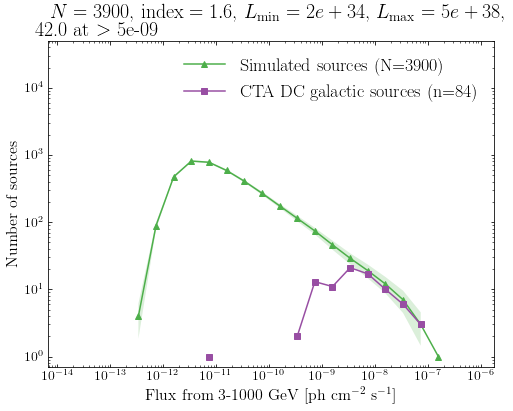

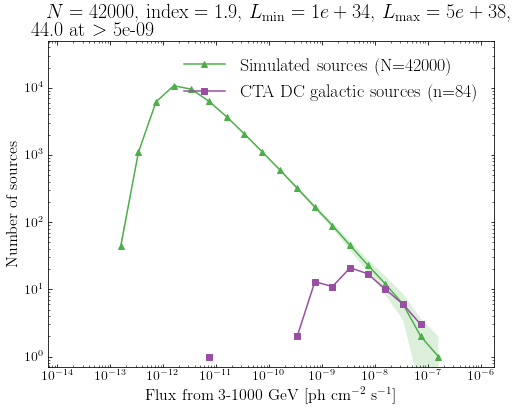

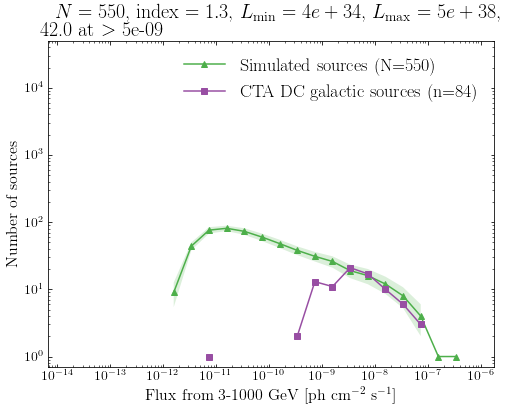

In [55]:
###3FGL snr run
ft = 1e-9
frac_op = []
std_frac_op = []
N3fgl = 10000
LF_i_3fgl = 1.8
Lmin_3fgl = 4e34
Lmax_3fgl = 1e39
bins_mean = bins_mean_3fgl
hist_norm = hist_3fgl_snr
ft = 5e-9

options_snr = [(3900,1.6,2e34,5e38),(42000,1.9,1e34,5e38),(550,1.3,4e34,5e38)]

for op in options_snr:

    N,a,Lmin,Lmax = op
    lb_frac_snr,std_lb_frac_snr,hist_snr,std_hist_snr,mp = ave_samples(100,Nsnr=N,LF_i_snr=a,
                                Lmin_snr=Lmin,Lmax_snr=Lmax,
                               alpha=alp,beta=bet,H=H,
                               ft=ft,spectrum=ave_spec_3fgl_snr,cm=True, data='3FGL')

    plot_hist_func(bins_mean,hist_snr,std_hist_snr,hist_norm,op,ft)
    chi2 =  lnlike(hist_norm[bins_mean>ft], hist_snr[bins_mean>ft])
    counts_sim = np.sum(hist_snr[bins_mean>ft])
    counts_norm = np.sum(hist_norm[bins_mean>ft])
    print '3FGL no. sources at flux > %s: %s'%(ft,counts_norm)
    print 'Simulation no. sources at flux > %s: %s'%(ft,counts_sim)
    print '-2lnL = %s'%chi2
    frac_op.append(lb_frac_snr)
    std_frac_op.append(std_lb_frac_snr)
# mp[mp==0]=1e-16

# fig = plt.figure(figsize=(25,10))
# ax = fig.add_subplot(111)
# ax.set_xticks([0,180,360,540,720])
# ax.set_xticklabels([0,90,180,270,360])
# ax.set_yticks([0,90,180,270,360])
# ax.set_yticklabels([90,45, 0,-45,-90])
# ax.set_ylim([140,220])
# ax.set_xlabel('l')
# ax.set_ylabel('b')
# im = ax.imshow(np.log10(mp[:,:]),cmap='hot',vmin=-13,vmax=-9)
# fig.colorbar(im,orientation='horizontal',shrink=0.5);


Doing 100 sample galaxys with 18000 sources,LF_i = 1.8, Lmin = 6e+34,Lmax=2e+38, 
        this might take some time...
...done
3FGL no. sources at flux > 2e-09: 268
Simulation no. sources at flux > 2e-09: 253.0
-2lnL = 279.410968412
Doing 100 sample galaxys with 100000 sources,LF_i = 2.1, Lmin = 3e+34,Lmax=2e+38, 
        this might take some time...
...done
3FGL no. sources at flux > 2e-09: 268
Simulation no. sources at flux > 2e-09: 249.0
-2lnL = 285.139154955
Doing 100 sample galaxys with 3500 sources,LF_i = 1.5, Lmin = 1.2e+35,Lmax=2e+38, 
        this might take some time...
...done
3FGL no. sources at flux > 2e-09: 268
Simulation no. sources at flux > 2e-09: 238.0
-2lnL = 282.103963964


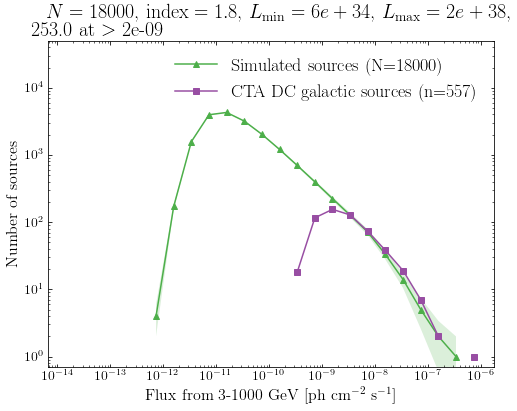

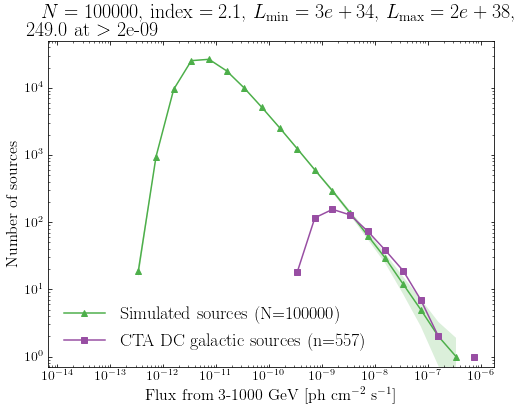

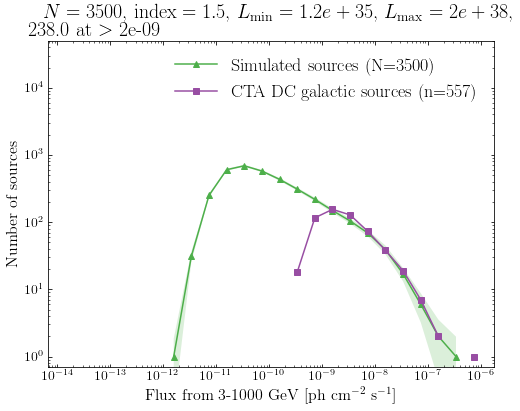

In [56]:
##3fgl lat < 5 sources

ft = 1e-9

N = 25000
LF_i = 1.8
Lmin = 4e34
Lmax = 1e39
bins_mean = bins_mean_3fgl
hist_norm = hist_3fgl_roi
ft = 2e-9

options_roi = [(18000,1.8,6e34,2e38),(100000,2.1,3e34,2e38),(3500,1.5,1.2e35,2e38)]

for op in options_roi:
    N,a,Lmin,Lmax = op
    lb_frac_roi,std_lb_frac_roi,hist_snr,std_hist_snr,mp = ave_samples(100,Nsnr=N,LF_i_snr=a,
                                Lmin_snr=Lmin,Lmax_snr=Lmax,
                               alpha=alp,beta=bet,H=H,
                               ft=ft,spectrum=ave_spec_3fgl_roi,cm=True, data='3FGL')

    plot_hist_func(bins_mean,hist_snr,std_hist_snr,hist_norm,op,ft)
    chi2 =  lnlike(hist_norm[bins_mean>ft], hist_snr[bins_mean>ft])
    counts_sim = np.sum(hist_snr[bins_mean>ft])
    counts_norm = np.sum(hist_norm[bins_mean>ft])
    print '3FGL no. sources at flux > %s: %s'%(ft,counts_norm)
    print 'Simulation no. sources at flux > %s: %s'%(ft,counts_sim)
    print '-2lnL = %s'%chi2

    frac_op.append(lb_frac_roi)
    std_frac_op.append(std_lb_frac_roi)

Doing 100 sample galaxys with 3000 sources,LF_i = 1.5, Lmin = 2e+31,Lmax=2e+35, 
        this might take some time...
...done
3FGL no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 122.0
-2lnL = 5.91088422389
Doing 100 sample galaxys with 22000 sources,LF_i = 1.8, Lmin = 1e+31,Lmax=2e+35, 
        this might take some time...
...done
3FGL no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 127.0
-2lnL = 12.950878228
Doing 100 sample galaxys with 700 sources,LF_i = 1.2, Lmin = 4e+31,Lmax=2e+35, 
        this might take some time...
...done
3FGL no. sources at flux > 1e-12: 128
Simulation no. sources at flux > 1e-12: 129.0
-2lnL = 8.90720899978


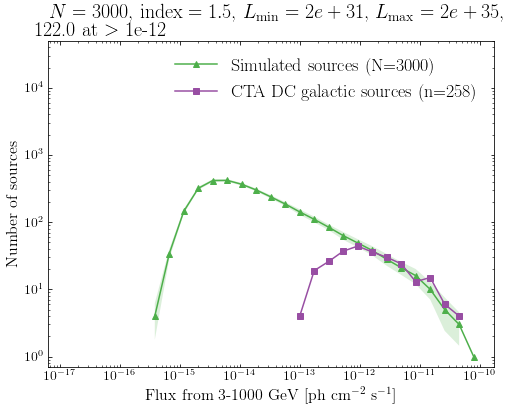

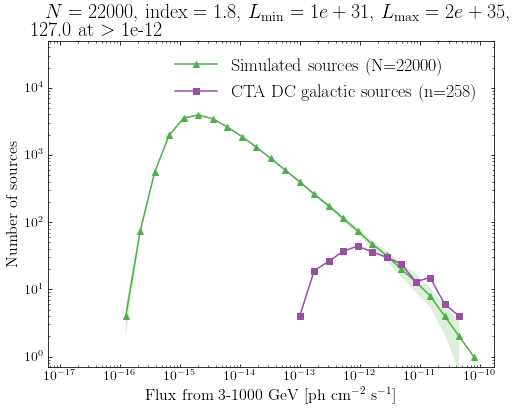

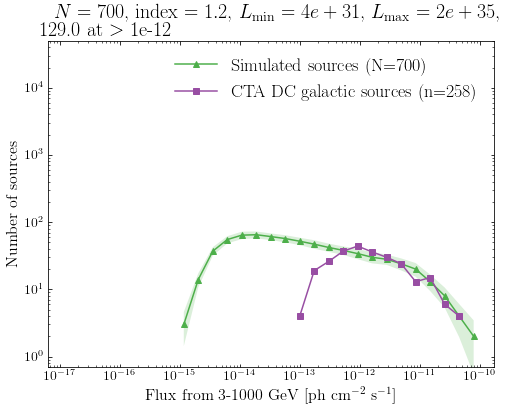

In [57]:
##3fgl lat < 5 sources

ft = 1e-9

N = 5000
LF_i = 1.5
Lmin = 1e31
Lmax = 1e35
bins_mean = bins_mean_CTA
hist_norm = hist_CTA
ft = 1e-12

options_CTA = [(3000,1.5,2e31,2e35),(22000,1.8,1e31,2e35),(700,1.2,4e31,2e35)]

for op in options_CTA:
    N,a,Lmin,Lmax = op
    lb_frac_CTA,std_lb_frac_CTA,hist_snr,std_hist_snr,mp = ave_samples(100,Nsnr=N,LF_i_snr=a,
                                Lmin_snr=Lmin,Lmax_snr=Lmax,
                               alpha=alp,beta=bet,H=H,
                               ft=ft,spectrum=ave_spec_CTA,cm=True, data='CTA')

    plot_hist_func(bins_mean,hist_snr,std_hist_snr,hist_norm,op,ft)
    chi2 =  lnlike(hist_norm[bins_mean>ft], hist_snr[bins_mean>ft])
    counts_sim = np.sum(hist_snr[bins_mean>ft])
    counts_norm = np.sum(hist_norm[bins_mean>ft])
    print '3FGL no. sources at flux > %s: %s'%(ft,counts_norm)
    print 'Simulation no. sources at flux > %s: %s'%(ft,counts_sim)
    print '-2lnL = %s'%chi2

    frac_op.append(lb_frac_CTA)
    std_frac_op.append(std_lb_frac_CTA)

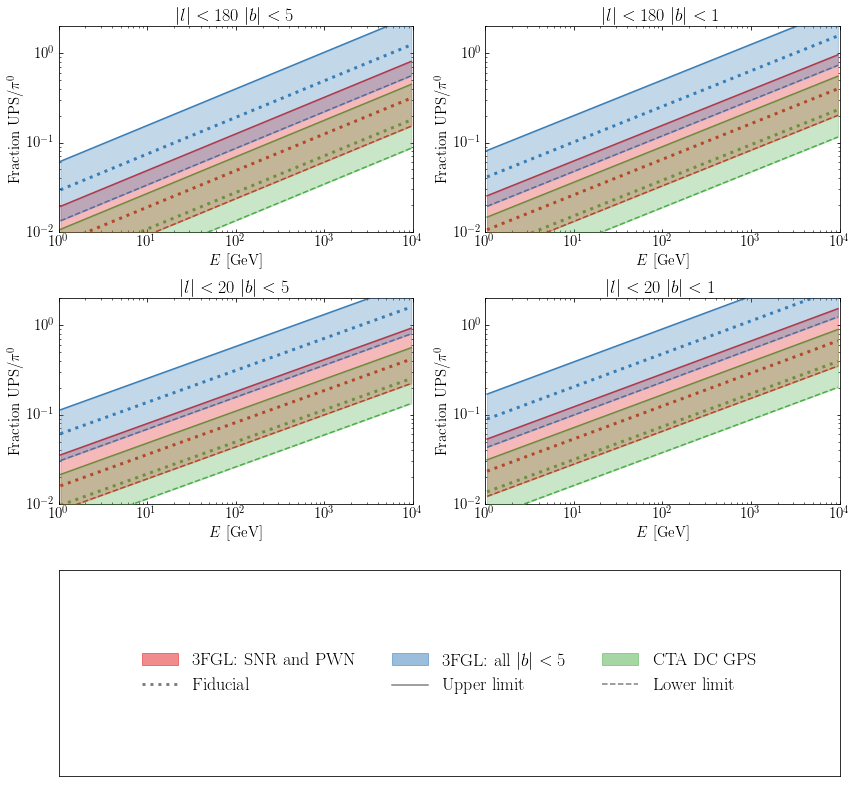

In [100]:
###Plot the fraction of unresolved/diffuse at different l,b
frac_op = np.array(frac_op)
std_frac_op = np.array(std_frac_op)

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3,2)
mask_lb = np.array([False,True,True,False,True,True])
_lb = np.array(lb)[mask_lb]
for di in range(len(_lb)):
    #print "At abs(l,b):",lb[di]
    gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[di])
    ax = plt.Subplot(fig,gs[di]) 
    
#     maskE_3fgl = (E>=1)&(E<=100)
    maskE_3fgl = (E>=1)
    
    
    
    ax.loglog(E[maskE_3fgl],frac_op[1,di,:][maskE_3fgl],label='SNR/PWN',color=colors[5],zorder=2)
#     ax.loglog(E[~maskE_3fgl],frac_op[0,di,:][~maskE_3fgl],color=colors[5],ls=':')
    ax.loglog(E[maskE_3fgl],frac_op[2,di,:][maskE_3fgl],label='SNR/PWN',color=colors[5],ls='--',zorder=2)
#     ax.loglog(E[~maskE_3fgl],frac_op[1,di,:][~maskE_3fgl],color=colors[5],ls='-.')
    ax.fill_between(E,frac_op[1,di,:],frac_op[2,di,:],color=colors[5],label='SNR/PWN',alpha=0.3,zorder=10)
    

    ax.loglog(E[maskE_3fgl],frac_op[4,di,:][maskE_3fgl],label='ROI',color=colors[1],zorder=2)
#     ax.loglog(E[~maskE_3fgl],frac_op[2,di,:][~maskE_3fgl],color=colors[1],ls=':')
    ax.loglog(E[maskE_3fgl],frac_op[5,di,:][maskE_3fgl],label='ROI',color=colors[1],ls='--',zorder=2)
#     ax.loglog(E[~maskE_3fgl],frac_op[3,di,:][~maskE_3fgl],color=colors[1],ls='-.')
    ax.fill_between(E,frac_op[4,di,:],frac_op[5,di,:],color=colors[1],label='SNR/PWN',alpha=0.3,zorder=10)
    

    ax.loglog(E[maskE_3fgl],frac_op[7,di,:][maskE_3fgl],label='CTA',color=colors[2],zorder=2)
#     ax.loglog(E[maskE_3fgl],frac_op[4,di,:][maskE_3fgl],color=colors[2],ls=':')
    ax.loglog(E[maskE_3fgl],frac_op[8,di,:][maskE_3fgl],label='CTA',color=colors[2],ls='--',zorder=2)
#     ax.loglog(E[maskE_3fgl],frac_op[5,di,:][maskE_3fgl],color=colors[2],ls='-.')
    ax.fill_between(E,frac_op[7,di,:],frac_op[8,di,:],color=colors[2],label='CTA',alpha=0.3,zorder=10)

    ax.loglog(E,frac_op[0,di,:],label='SNR/PWN best fit', color=colors[5],lw=3,ls=':',zorder=1)
    ax.loglog(E,frac_op[3,di,:],label='ROI best fit', color=colors[1],lw=3,ls=':',zorder=1)
    ax.loglog(E,frac_op[6,di,:],label='CTA best fit', color=colors[2],lw=3,ls=':',zorder=0)
    ax.set_xscale('log',nonposx='clip')
    ax.set_yscale('log',nonposy='clip')

#     ax.fill_between(E,frac_op[6,di],frac_op[4,di],alpha=0.2,facecolor=colors[0])
#     ax.fill_between(E,frac_op[4,di],frac_op[2,di],alpha=0.2,facecolor=colors[0])
    ax.set_ylim([0.01,2])
    ax.set_xlim([1,1e4])
    ax.set_title(r'$|l| < %s \ |b| < %s$'%(_lb[di,0],_lb[di,1]),fontsize=18)
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=15)
    ax.set_xlabel(r"$E$ [GeV]",fontsize=15)
    ax.set_ylabel(r'Fraction $\rm UPS/ \pi^0$',fontsize=15)
    fig.add_subplot(ax)
    #plt.legend(loc=2,frameon=False,fontsize=15,ncol=2)#, title=options_labels[0:4])
##Plot legend in seperate subplot
plt.gca().set_prop_cycle(None)
gsi = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gs[di+1])

ax = plt.subplot(gs[-1,:]) 
p1=ax.fill_between([0],[0],[0],label='3FGL: SNR and PWN',color=colors[5],alpha=0.5)
p2=ax.fill_between([0],[0],[0],label=r'3FGL: all $|b| < 5$',color=colors[1],alpha=0.5)
p3=ax.fill_between([0],[0],[0],label='CTA DC GPS',color=colors[2],alpha=0.5)
p4=ax.plot(0,0,label='Fiducial',ls=':',color='grey',lw=3)
p5=ax.plot(0,0,label='Upper limit',ls='-',color='grey')
p6=ax.plot(0,0,label='Lower limit',ls='--',color='grey')
handles, labels = ax.get_legend_handles_labels()
ax.set_frame_on(True)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(ax)
lg = plt.legend([handles[3],handles[0],handles[4],handles[1],handles[5],handles[2]],
                [labels[3],labels[0],labels[4],labels[1],labels[5],labels[2]],
                loc=10,frameon=False,ncol=3,fontsize=18)
# lg = plt.legend([handles[0],handles[3],handles[1],handles[4],handles[2],handles[5]],
#                 labels=[labels[0],labels[3],labels[1],labels[4],labels[2],labels[5]],
#                 loc=10,frameon=False,ncol=3,fontsize=18)
# lg.get_title().set_fontsize(18)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig('fraction_ups_compare.pdf')